#### CMSE 201 Final Project
### Tom Ladouceur
### Section 005
#### 12/02/2019

# Solving a Fun Puzzle using Python

## Background and Motivation

Puzzles and inquires in math can be just simply fun to solve, or unlock new ways to learn about how to approach problems and expand the knowledge of mathematics, which can be used to solve new problems in the future. This problem, which I have never known the answer to, is one I came up with a couple years ago. It is a fun problem to attempt to solve by hand and comparing personal bests with friends, but I wanted to know the best solution.
   
The problem or game, which is called ichi, goes as following: Start with an empty square grid that hypothetically goes on forever. The player starts by added 2 ones anywhere they want, although they have to be relatively close to each other, as you will see in a moment. Then from that point on the player adds numbers to the grid sequential starting with two, ie 2,3,4,5,6,7 etc. Each number can only be placed where the 8 surrounding numbers currently on the board sum to equal that number. So to add the first two, it has to touch both the original ones, either diagonally or adjacently. Try once before seeing the best answers and try to get as far as you can. Below is an example of a possible board, although not a great example.
   
After I solve this problem and see what the best solution is, I would then like to see what the best is start with 3 ones instead of 2. I imagine it would grow a lot the more ones you start with, but how this growth occurs is the question I would like to answer, but I would imagine it would be too computational hard to add too many ones, so this might not be the best way to answer that later question. 


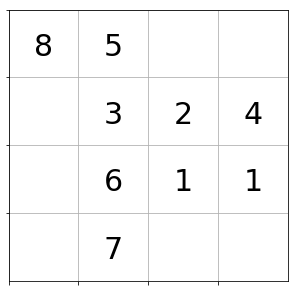

## Methodology

This problem will require a lot of recursion and the changing of some grid, which will be the board. I will go through every unique board, checking every one to find the best board. It seems natural to me to represent this board as a 2d numpy array, as left, right, up, and down are well defined and printing it out just naturally froms a grid of numbers. So I set up numpy, and matplotlib to display the complete boards, and anytree, to store all the values of possible grids.

In [1]:
import numpy as np
from IPython.display import display, clear_output
%matplotlib inline
import matplotlib.pyplot as plt
import anytree
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import time
from IPython.display import Image

First I set up a way to initialize the board, an empty board with a single one in the center

In [2]:
def make_board(size = 7):
    board = np.zeros((size,size))
    board[int(size/2),int(size/2)] = 1
    return board

Then I make a function to set up the 'roots' of the tree, which are the last one placed. This is a simple function, but will be useful to change later if I want to add more one. There are only 5 places for the next one to be placed as their are symmetries that can be ignored, simplifying the calculation as a whole. Each node display name is in relation to the initial, how much lower and how much to the right.

In [3]:
def set_roots(start):
    #Creates 5 nodes for the 5 unique starting positions of ones, with each being children of the start (0,0) node
    #Each is named a unique number, but displayed as the position that it is placed at
    roots = [Node('1',parent=start, display_name='(0,-1)'),Node('2',parent=start, display_name='(0,-2)'),Node('3',parent=start, display_name='(-1,-1)'),Node('4',parent=start, display_name='(-1,-2)'),Node('5',parent=start, display_name='(-2,-2)')]
    newRoots = roots
    return newRoots

Then I need a function to add numbers in the future, by taking in where they are on the tree of nodes, and creating the board from there.

In [4]:
#Takes in spot, which is a string which looks like a tuple of ints
def place_found(board, spot, lookingFor):
    #Makes the spot into a tuple of strings
    spot = tuple(spot[1:-1].split(','))
    #Turns the string into an int, which the number changed into the actual spot of the board, from its relation to the center
    i = int(spot[0])+int(len(board[0])/2)
    j = int(spot[1])+int(len(board[0])/2)
    newBoard = board
    #Places the number at the spot
    newBoard[i,j] = lookingFor
    return newBoard

In [5]:
#Takes the directory of whereOnTree and returns the exact node of the tree the machine are currently on.
def current_spot(whereOnTree, roots):
    #Starts at the root node
    currentNode = roots[whereOnTree[0]]
    #For each of the next spots of the directory move to that number node of the children
    for i in whereOnTree[1:]:
        currentNode = currentNode.children[i]
    return currentNode

To prevent issues, I create the board from scratch each time, which may be computational more difficult, but prevents errors, such as multiple numbers or numbers not being successfully erased later in the board.

In [6]:
def set_board(roots, whereOnTree = [0], size = 7):
    #Creates the new board from scratch
    newBoard = make_board(size)
    #places the second one
    newBoard = place_found(newBoard, roots[whereOnTree[0]].display_name, 1)
    #Places all of the following numbers, starting with 2
    for i in range(1,len(whereOnTree)+1):
        place = current_spot(whereOnTree[0:i], roots).display_name #Defines the spot of that number
        newBoard = place_found(newBoard, place, i) #Places it
    return newBoard

Now I define the variables I will be using through the process of creating all the boards.

In [7]:
#Unchanging Variables

size = 7 #Start with a size 7 board
start = Node('0', display_name='(0,0)') #Creates the root node of the tree, at the center
roots = set_roots(start) #Sets the roots, the last '1' of each board

#Changing Variables
recordBoard = np.array([]) #To store the record boards
record = 0 #To define the current highest number found

nodeNum = 6 #To name each node individually, so they arent confused with each other later
lookingFor = 2 #The current number that is being looked for on the board
whereOnTree = [0] #The directory of where we are on the tree
board = make_board(size) #Creates the board
board = set_board([roots[0]], size=size) #Adds the second one to start

#Statistic Variables
leafs = []

Since many of the boards are symmetrical of each other, either rotated or flipped of another one, they are essentially the same board, so to prevent the computer from needing to compute all of these this finds and eliminates any symmetries.

In [8]:
def find_symmetries(board, spots):
    newSpots = [] #What the function will return
    newSpots = spots #initially set it to the spots with duplicates
    
    #There cant be duplicates if only one exists
    if len(spots) > 1:
        
        test = np.copy(board) #Creates a copy of the board to change

        #Removes all the unnecessary ones on the outer parts of the board
        moves = [0,0,0,0] #Records how many rows and column of ones were removed
        #Removes top rows if only zeros
        while all(test[0] == 0):
            test = np.delete(test,0,0)
            moves[0] += 1
        #Removes bottom rows if only zeros
        while all(test[-1] == 0):
            test = np.delete(test,-1,0)
            moves[1] += 1
        #Removes left columns if only zeros
        while all(test[:,0] == 0):
            test = np.delete(test,0,1)
            moves[2] += 1
        #Removes right columns if only zeros
        while all(test[:,-1] == 0):
            test = np.delete(test,-1,1)
            moves[3] += 1

        #defines the center of the new board to be rotated and fliped over
        dy = (len(board[0])-1+moves[0]-moves[1])/2
        dx = (len(board[0])-1+moves[2]-moves[3])/2

        #All eight possible symmetries of the board
        possibles = np.array([('-x','y'),('-y','-x'),('x','-y'),('x','y'),('y','-x'),('-x','-y'),('-y','x')])
        #True false value of whether the board has that symmetry
        isSym = [False,False,False,False,False,False,False]

        #Tests all eight of the symmetries
        if np.array_equal(np.rot90(test),test):
            isSym[0] = True
        if np.array_equal(np.rot90(np.rot90(test)),test):
            isSym[1] = True
        if np.array_equal(np.rot90(np.rot90(np.rot90(test))),test):
            isSym[2] = True
        if np.array_equal(test.T,test):
            isSym[3] = True
        if np.array_equal(np.rot90(test.T),test):
            isSym[4] = True
        if np.array_equal(np.rot90(np.rot90(test.T)),test):
            isSym[5] = True
        if np.array_equal(np.rot90(np.rot90(np.rot90(test.T))),test):
            isSym[6] = True
        
        #If the board contains any of the symmetries
        if any(isSym):
            #Creates a tuple to see if it a symmetry of any of the current spots
            check = (0,0)
            for spot in spots:
                #Turns the current spots into the actual integer tuple of the (y,x) values of the spot on the board
                spotT = spot
                spotT = tuple(spotT[1:-1].split(','))
                spotT = (float(spotT[0])+int(len(board[0])/2),float(spotT[1])+int(len(board[0])/2))
                #For each of the symmetries for each of the spots
                for s in possibles[isSym]:
                    #Turns check into the symmetrical spot on the board
                    if s[0] == 'x':
                        check = (spotT[1]-dx+dy-int(len(board[0])/2),check[1])
                    elif s[0] == '-x':
                        check = (-(spotT[1]-dx)+dy-int(len(board[0])/2),check[1])
                    elif s[0] == 'y':
                        check = (spotT[0]-int(len(board[0])/2),check[1])
                    elif s[0] == '-y':
                        check = (-spotT[0]+2*dy-int(len(board[0])/2),check[1])
                    if s[1] == 'x':
                        check = (check[0],spotT[1]-int(len(board[0])/2))
                    elif s[1] == '-x':
                        check = (check[0],-spotT[1]+2*dx-int(len(board[0])/2))
                    elif s[1] == 'y':
                        check = (check[0],spotT[0]-dy+dx-int(len(board[0])/2))
                    elif s[1] == '-y':
                        check = (check[0],-(spotT[0]-dy)+dx-int(len(board[0])/2))
                    #Make sure check is a whole number then converts it into an int
                    if np.floor(check[0]) == check[0] and np.floor(check[1]) == check[1]:
                        check = (int(check[0]),int(check[1]))
                    #If the symmetry actually changed the spot
                    if "{}".format(check) != spot:
                        #Remove all instances of the symmetrical spot, only left with unique spots
                        newSpots[:] = [x for x in newSpots if x != "{}".format(check)]
    return newSpots

I need to be able to find the spots on the board cuurently available to place the next number

In [9]:
def find_available(board, lookingFor):
    spots = [] #The spot that the function will return
    #Goes through all the spots excluding the edges as that will cause an issue because there would not be 8 values surrounding it
    for i in range(1,len(board[0])-1):
        for j in range(1,len(board[0])-1):
            if board[i,j] == 0: #Cant place a number if another one is already there
                #Sum up all 8 surrounding values
                surrsum = board[i-1,j-1]
                surrsum += board[i,j-1]
                surrsum += board[i+1,j-1]
                surrsum += board[i-1,j]
                surrsum += board[i+1,j]
                surrsum += board[i-1,j+1]
                surrsum += board[i,j+1]
                surrsum += board[i+1,j+1]
                #If it is a spot that the nxt number can be placed, add it to the list
                if surrsum == lookingFor:
                    spots.append('{}'.format((i-int(len(board[0])/2),j-int(len(board[0])/2))))
    spots = find_symmetries(board, spots) #Remove duplicates
    return spots

In order for the directory, whereOnTree, to be useful the tree as a whole needs to be save, using nodes and children, which would allow us to look at it later too.

In [10]:
def make_tree_spot(whereOnTree, lookingFor, spots, roots, nodeNum):
    #Defines the current node
    currentNode = current_spot(whereOnTree, roots)
    #For each of the spots available make them children of the current node
    for spot in spots:
        Node(str(nodeNum), parent=currentNode, display_name="{}".format(spot))
        nodeNum += 1
    return nodeNum

If the board expands near the edge of the board, it will need to be expanded, so its not constrained to the limits of the current board, but could go on forever.

In [11]:
def on_edge(board, spot):
    #Current spot
    spot = tuple(spot[1:-1].split(','))
    #If it is near the edge, one away
    iTooFar = int(spot[0])+int(len(board[0])/2) <= 1 or int(spot[0])+int(len(board[0])/2) >= len(board[0])-2
    jTooFar = int(spot[1])+int(len(board[0])/2) <= 1 or int(spot[1])+int(len(board[0])/2) >= len(board[0])-2
    #If it is return true
    if iTooFar or jTooFar:
        return True
    else:
        return False

In [12]:
#Expands the board
def expand_board(board):
    #returns the same board surrounded by ones
    return np.pad(board, [(1, 1), (1, 1)], mode="constant", constant_values=0)

Now it has to iterate through all the options, building the tree until it runs out of places to go

In [ ]:
#While it hasnt exausted all the options
while len(whereOnTree) > 0:
    #Defines the available places to put the next number
    spots = find_available(board, lookingFor)
    #If there is a spot available
    if len(spots) > 0:
        #Adds it to the tree
        nodeNum = make_tree_spot(whereOnTree, lookingFor, spots, roots, nodeNum)
        #Adds the first new spot to our directory
        whereOnTree.append(0)
        #Places the number on the new spot
        board = place_found(board, spots[0], lookingFor)
        #Now looking for next number
        lookingFor += 1
        #Makes board bigger if it is close to the edge, to prevent boundary issues
        if on_edge(board,spots[0]):
            board = expand_board(board)
    else:
        #Add the value to array of endpoints
        leafs.append(len(whereOnTree))
        #If its a record record it
        if len(whereOnTree)>record:
            recordBoard = list([np.copy(board)])
            record = len(whereOnTree)
        elif len(whereOnTree)==record:
            recordBoard.append(list(np.copy(board)))
        #Make sure it hasn't exhausted all the possibilities and it goes back one step if it cannot move horizontatlly
        while len(whereOnTree) > 0 and len(current_spot(whereOnTree, roots).siblings)-1 < whereOnTree[-1] and len(whereOnTree) != 1:
            #Removes current spot
            currSpot = tuple(current_spot(whereOnTree, roots).display_name[1:-1].split(','))
            
            board[int(currSpot[0])+int(len(board[0])/2),int(currSpot[1])+int(len(board[0])/2)] = 0
            #Removes it from the current directory
            if len(whereOnTree) > 1 or whereOnTree[0] >= len(roots)-1:
                whereOnTree.pop()
                #Changes to the next lowest number
                lookingFor -= 1
    
        #Make sure it hasn't exhausted all the possibilities and all the roots
        if len(whereOnTree) > 0 and (len(whereOnTree) > 1 or whereOnTree[0] < len(roots)-1):
            #Removes it from the board
            currSpot = tuple(current_spot(whereOnTree, roots).display_name[1:-1].split(','))
            board[int(currSpot[0])+int(len(board[0])/2),int(currSpot[1])+int(len(board[0])/2)] = 0
            #Moves horizontally on the tree
            whereOnTree[-1] += 1
            #Places it on board
            size = len(board[0])
            board = set_board(roots, whereOnTree, size=size)
        else:
            #if it has exhausted all the possibilities end the game
            whereOnTree = []
print('There were {} total nodes on the tree'.format(nodeNum)) #How many total nodes are on the tree, ie possible boards in total
print('The highest number possible is {}'.format(record))

I will save the tree created as a png of a Dot File to show the results later

In [14]:
DotExporter(start, nodeattrfunc=lambda node:'label="{}"'.format(node.display_name)).to_picture("TotalTree.png")
DotExporter(roots[2], nodeattrfunc=lambda node:'label="{}"'.format(node.display_name)).to_picture("root2.png")


Now that it successfully went through all the results for 2 ones quite quickly, I can adapt it to take more than one one initally, by changing the roots function and the set board function. The root is still the last 1 added, but is the descendant of the other ones placed. The set_board function now places all the anscestors of the root, allowing all the ones to be placed.

In [15]:
def set_roots(board, extraones, size, start):
    #Keep track of the number of the node
    nodeNum = 6
    #Makes a copy of the board
    newBoard = np.copy(board)
    #Creates 5 nodes for the 5 unique starting positions of ones, with each being children of the start (0,0) node
    #Each is named a unique number, but displayed as the position that it is placed at
    roots = [Node('1',parent=start, display_name='(0,-1)'),Node('2',parent=start, display_name='(0,-2)'),Node('3',parent=start, display_name='(-1,-1)'),Node('4',parent=start, display_name='(-1,-2)'),Node('5',parent=start, display_name='(-2,-2)')]
    newRoots = roots
    #For each new one added
    for i in range(extraones):
        newRoots = []
        #For each new root make a board with that root
        for r in roots:
            spots = []
            newBoard = set_board([r], size = size)
            for i in range(len(newBoard[0])):
                for j in range(len(newBoard[0])):
                    #Create a root with a one at each of the spots on the board
                    if newBoard[i,j] == 0:
                        spots.append('{}'.format((i-int(size/2),j-int(size/2))))
            #Get rid of the symmetries
            spots = find_symmetries(newBoard, spots)
            #Add those spots and make them the new roots
            for spot in spots:
                newRoots.append(Node(nodeNum,parent=r, display_name=spot))
                nodeNum += 1
            newBoard = np.copy(board)
        roots = newRoots
    return newRoots
            

In [16]:
def set_board(roots, whereOnTree = [0], size = 7):
    #Creates the new board from scratch
    newBoard = make_board(size)
    #places the second one
    newBoard = place_found(newBoard, roots[whereOnTree[0]].display_name, 1)
    
    #Places all the ancestors of the root, which are ones
    for an in roots[whereOnTree[0]].ancestors:
        newBoard = place_found(newBoard, an.display_name, 1)
     
    #Places all of the following numbers, starting with 2
    for i in range(1,len(whereOnTree)+1):
        place = current_spot(whereOnTree[0:i], roots).display_name #Defines the spot of that number
        newBoard = place_found(newBoard, place, i) #Places it
    return newBoard

By changing the variables slightly, using the new functions, with an extra one, and a bigger board to allow every possibility of starts, we can use the old bulk of code to find the highest board with 3 ones.

In [53]:
#Unchanging Variables
size = 15 #Start with a size 15 board
start = Node('0', display_name='(0,0)') #Creates the root node of the tree, at the center
board = make_board(size) #Creates the board
roots = set_roots(board, 2, size, start=start) #Sets the roots, the last '1' of each board
board = set_board([roots[0]], size=size ) #Adds the ones to start

#Changing Variables

nodeNum2 = 6 #The number of the nodes
lookingFor = 2 #Which number is currently being looked for
whereOnTree = [0] #The start of the directory


## Results

The tree resulting from every possibility is large, but smaller than expected, with 537 nodes in total. Each node represents a placement of numbers, and can be easily visualized in a chart. Below is an image of all possible boards, starting the the second one being placed at (-1,-1) or one diagonal from the initial 1. With that starting position the deepest you can get is 15, which is only one away from optimal. Most random ways, which is what I was doing by hand end around 7, so it is difficult to pick the exact way to get the optimal board. 

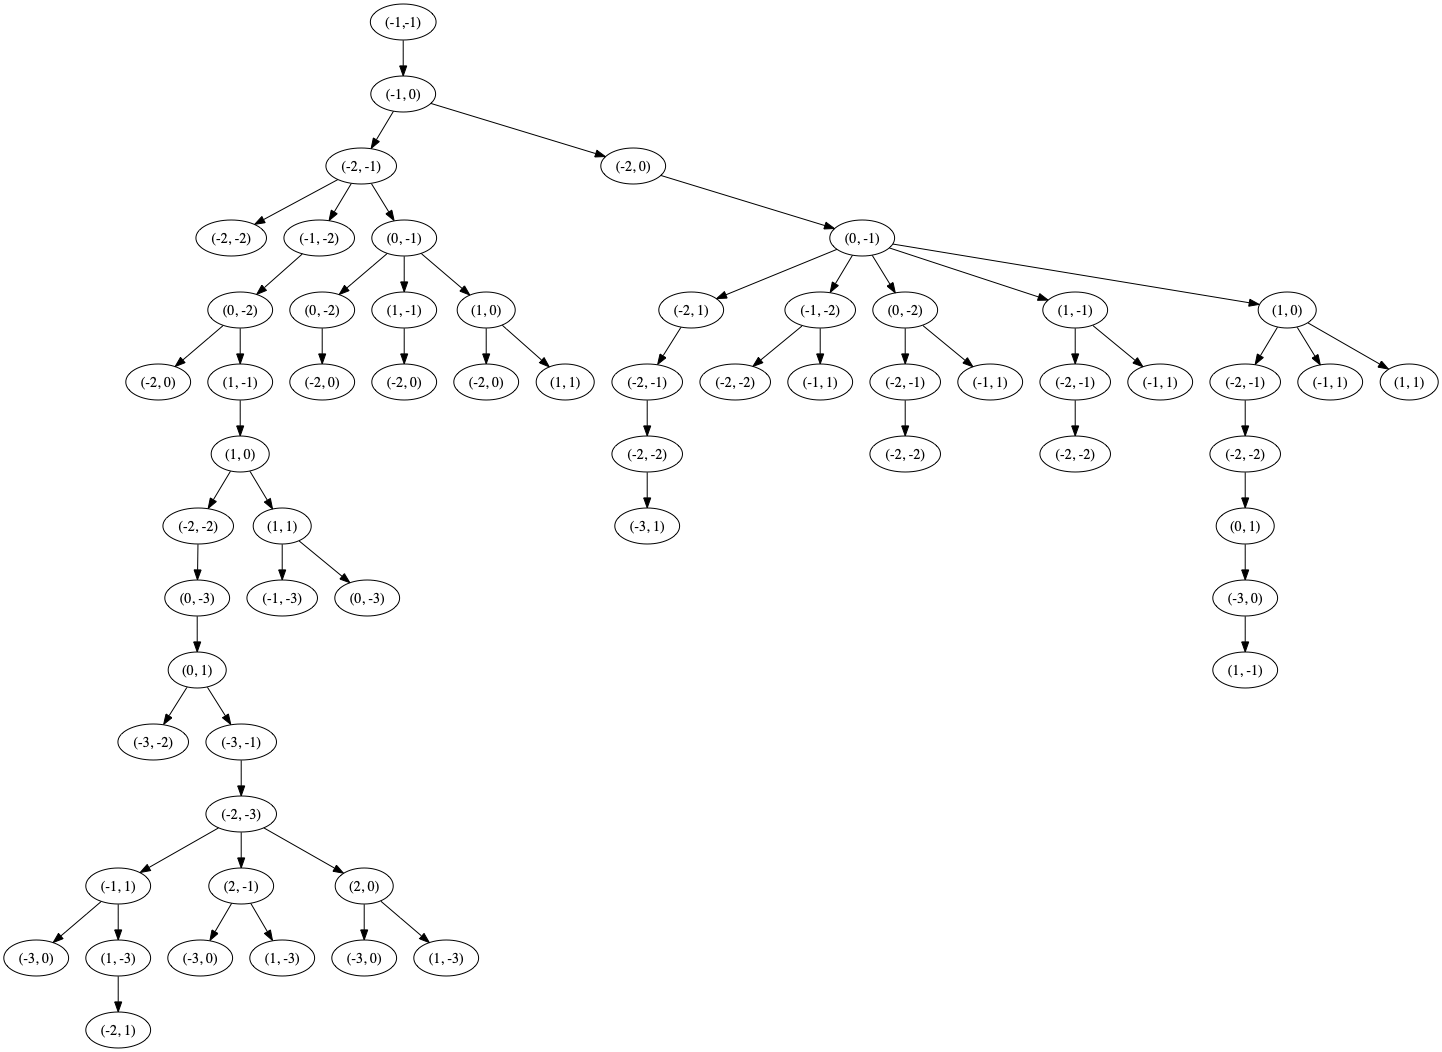

In [18]:
Image("root2.png")

In [34]:
#A function to show a board in a cool way
def draw_board(grid, record):
    
    #Creates a copy
    test = grid
    
    #Removes all the excess ones on the side
    while all(test[0] == 0):
        test = np.delete(test,0,0)
    while all(test[-1] == 0):
        test = np.delete(test,-1,0)
    while all(test[:,0] == 0):
        test = np.delete(test,0,1)
    while all(test[:,-1] == 0):
        test = np.delete(test,-1,1)
        
    grid = test
    #Creates a figure
    fig = plt.figure(figsize=(5,5))
    #Adds grid lines to show the actual grid
    plt.grid()
    #For each number in the board
    for r in range(1,record+1):
        #Only true where the spot equals the value we are looking for
        tf = (grid == r)
        for i in range(len(grid[0])):
            for j in range(len(grid[:,0])):
                #Goes through each value looking for the correct spot
                if tf[j,i] == True:
                    #Sets the limits of the grid, which is the numbers on the array
                    plt.ylim(len(grid[:,0])+1,1)
                    plt.xlim(1,len(grid[0])+1)
                    #Gets rid of the numbers of the axis'
                    plt.xticks(np.arange(1,len(grid[0])+1),[])
                    plt.yticks(np.arange(1,len(grid[:,0])+1),[])
                    #Places the number in the center of the correct square
                    plt.text(i + 1.5, j+1.55,'{}'.format(r), horizontalalignment='center', verticalalignment='center', fontsize = 30)
                    #Waits to place the next number
                    clear_output(wait=True)
                    display(fig)
                    #time.sleep(.5)

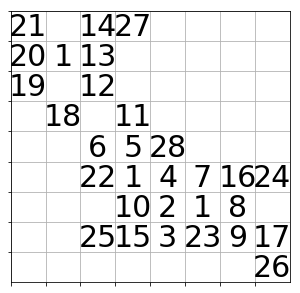

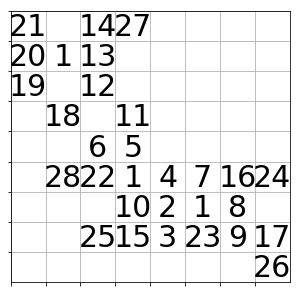

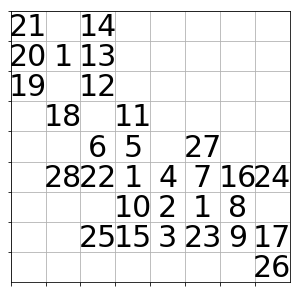

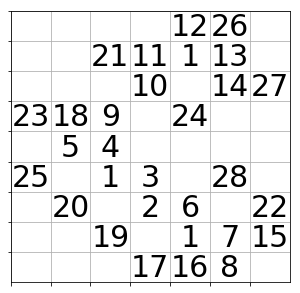

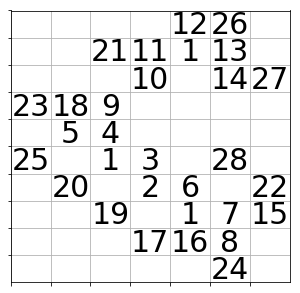

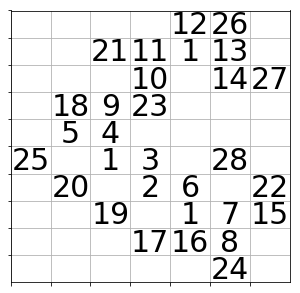

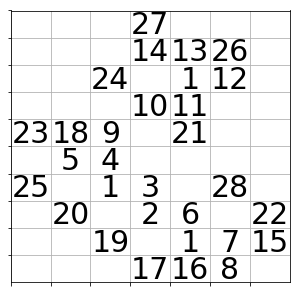

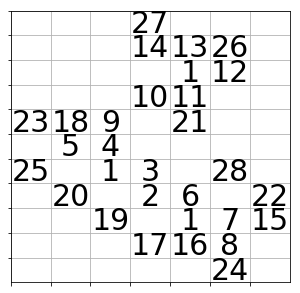

In [35]:
#Draws the ideal boards, if there is more than one
for r in recordBoard:
    draw_board(r,record)
clear_output()

On average a random person will end at 12.451303128159964


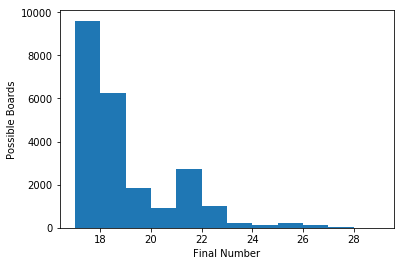

In [52]:
plt.hist(leafs, bins=range(17, 30, 1))
plt.xlabel('Final Number')
plt.ylabel('Possible Boards')
print('On average a random person will end at {}'.format(np.mean(leafs)))

The calculation starting with three ones took significantly longer, about 10 minutes, and the results revealed why, instead of there being 537 nodes, there were 408709 nodes in total. The optimal board result with 3 ones was 28, which is not significantly more than 2 ones, with a lot more computation. Since it took so much longer, I think 4 ones would be take for too much time, it would take days to compute.

## Discussion and Conclusion

With the recursion through every possible board, I was suprised how few possible boards there actually are. For this simulation, I learned how big this problem grows. Starting with only 2 ones, it is shown optimal board is 16, and for 3 ones, the optimal board is 28. How this would grow for then on is hard to see, as it computationally grows drastically. While creating the recursion I ran into a lot of errors, and next time I would not recreate the whole board each time, as this may be very computationally expensive, so I could just modify it slightly when needed. I learned the ideal solutions for the first two problems, but the second one took 731 times as many calculations to compute, so it could be optimized better. Not every third 1 used when I computed the second problem actaully affected the outcome, so to make this better I could use only the position of ones where they can be reached by the other numbers, no in some distant spot unreachable, so not making the final number any larger. The solutions were satisfying in finally knowing, and are well defined in this problem.